In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import sqlite3
import os
import json

# Part 1. Aggregate the trades (by time and side)

In [15]:
TRADES_DIR = '../TRADES/USD_TOM_trades_Micex_02_10.feather'

In [16]:
trade = pd.read_feather(TRADES_DIR)

In [17]:
trade_temp = trade.groupby(['Time', 'AGGRESSOR_SIDE'], as_index=False).sum()

In [18]:
volume_weighted_trade_price = trade_temp['TRADE_VALUE'] / trade_temp['SIZE'] / 1000.0

In [19]:
trade_temp['PRICE'] = volume_weighted_trade_price
# round to 0.01 of cent
trade['PRICE'] = trade['PRICE'].round(4)

In [20]:
trade = trade_temp

In [21]:
trade

,Time,AGGRESSOR_SIDE,PRICE,SIZE,TRADE_VALUE
0,2021-02-01 10:00:00.271880,B,75.606275,663,50126960.0
1,2021-02-01 10:00:00.304507,B,75.662500,10,756625.0
2,2021-02-01 10:00:00.346729,B,75.657500,3,226972.5
3,2021-02-01 10:00:00.360369,S,75.602500,20,1512050.0
4,2021-02-01 10:00:00.377261,S,75.602500,4,302410.0
...,...,...,...,...,...
4912947,2021-10-06 23:49:52.045505,B,72.415000,10,724150.0
4912948,2021-10-06 23:49:53.298854,S,72.402500,33,2389282.5
4912949,2021-10-06 23:49:54.198603,B,72.415000,8,579320.0
4912950,2021-10-06 23:49:56.315648,S,72.405000,49,3547845.0


# Part 2. Collect VWAP data

Let's collect VWAP prices info into *sqlite* database.
   
For buy and sell trades we will look on MID price (for 100k volume) on the nearest VWAP data **before** the trade<br>
    then on the MID price (for 100k volume) on nearest VWAP data before (trade + N seconds, N>=1).<br>

In [24]:
connection = sqlite3.connect('vwap.db3')

In [25]:
connection.executescript('''
DROP TABLE IF EXISTS "VWAP";

CREATE TABLE "VWAP" (
  "Time" TIMESTAMP,
  "100k.BID_VALUE" REAL,
  "100k.ASK_VALUE" REAL
);

CREATE INDEX "ix_VWAP_Time" ON "VWAP" ("Time");
''');

In [27]:
pathlist = Path('../VWAP_1_sec/').glob('./*.feather')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    print(path_in_str)
    
    vwap = pd.read_feather(path_in_str)
    vwap100k = vwap[['Time', '100k.BID_VALUE', '100k.ASK_VALUE']].dropna()

    vwap100k.to_sql('VWAP', connection, if_exists='append', index=False)

..\VWAP_1_sec\VWAP_1_sec_02.feather
..\VWAP_1_sec\VWAP_1_sec_03.feather
..\VWAP_1_sec\VWAP_1_sec_04.feather
..\VWAP_1_sec\VWAP_1_sec_05.feather
..\VWAP_1_sec\VWAP_1_sec_06.feather
..\VWAP_1_sec\VWAP_1_sec_07.feather
..\VWAP_1_sec\VWAP_1_sec_08.feather
..\VWAP_1_sec\VWAP_1_sec_09.feather
..\VWAP_1_sec\VWAP_1_sec_10.feather


In [28]:
connection.close()

# Part 3. Calculate market impact

In [29]:
connection = sqlite3.connect('vwap.db3')
cur = connection.cursor()

In [46]:
def price_before_big_trade(row):
    min_time_param = str(row['Time'] - np.timedelta64(5, 's'))
    time_param = str(row['Time']) # argument for sqlite
    
    record = cur.execute('SELECT * FROM VWAP where TIME BETWEEN ? AND ? ORDER BY TIME DESC LIMIT 1', [min_time_param, time_param])
    record = record.fetchone()
    if record:
        return (record[1] + record[2]) / 2
        

def price_after_big_trade(row, time_span):
    min_time_param = str(row['Time'] - np.timedelta64(5, 's'))
    time_param = str(row['Time'] + time_span) # argument for sqlite
    
    record = cur.execute('SELECT * FROM VWAP where TIME BETWEEN ? AND ? ORDER BY TIME DESC LIMIT 1', [min_time_param, time_param])
    record = record.fetchone()
    if record:
        return (record[1] + record[2]) / 2

In [30]:
def calculate_impact(big_trades):
    print('START', datetime.datetime.now())

    TOTAL_BUYS = big_trades[big_trades['AGGRESSOR_SIDE'] == 'B']['SIZE'].sum()
    TOTAL_SELLS = big_trades[big_trades['AGGRESSOR_SIDE'] == 'S']['SIZE'].sum()
    
    buys = big_trades[big_trades['AGGRESSOR_SIDE'] == 'B']
    sells = big_trades[big_trades['AGGRESSOR_SIDE'] == 'S']
    
    price_before_column = big_trades.apply(price_before_big_trade, axis='columns')
    
    impact_buys = []
    impact_sells = []

    for seconds in range(1, 31):
        price_after_column = big_trades.apply(price_after_big_trade, axis='columns', time_span=np.timedelta64(seconds, 's'))
        big_trades['price_change'] = price_after_column - price_before_column

        buys_impact = (buys['SIZE'] * big_trades['price_change']).sum() / TOTAL_BUYS
        sells_impact = (sells['SIZE'] * big_trades['price_change']).sum() / TOTAL_SELLS
        impact_buys.append(buys_impact)
        impact_sells.append(sells_impact)

    print('FINISH', datetime.datetime.now())
    
    return impact_buys, impact_sells

In [10]:
print_sizes = False

size_ranges = [(100, 500), 
               (500, 1000), 
               (1000, 2000) , (2000, 3000), (3000, 4000), (4000, 5000), (5000, 6000),
               (6000, 10001)
               # (1, 11)
              ]
for span in size_ranges:
    print(span)
    big_trades = trade[trade['SIZE'].between(left = span[0], right = span[1] - 1)]
    big_trades = big_trades.reset_index(drop = True)
    
    if print_sizes:
        # print how much trades available for a size range
        print('buys count:', len(big_trades[big_trades['AGGRESSOR_SIDE'] == 'B']))
        print('sells count:', len(big_trades[big_trades['AGGRESSOR_SIDE'] == 'S']))
    
    ibuy, isell = calculate_impact(big_trades)
    print(ibuy)
    print(isell)

(100, 500)
buys 496887
sells 579298
(500, 1000)
buys 73345
sells 59375
(1000, 2000)
buys 25326
sells 20521
(2000, 3000)
buys 4038
sells 3113
(3000, 4000)
buys 1318
sells 994
(4000, 5000)
buys 429
sells 466
(5000, 6000)
buys 324
sells 389
(6000, 10001)
buys 234
sells 286


In [30]:
cur.close()
connection.close()

# Part 4, result: Plots

I've copied calculation results into dictionaries:

In [13]:
results = {
    '100-499, buy': [0.0023124580628453707, 0.002427686303010858, 0.002457637986826581, 0.002495074626618635, 0.0025038754367175237, 0.0025259979451421857, 0.002547615641868739, 0.002556940358646317, 0.002565286397109942, 0.0025647554551556464, 0.002600342481186583, 0.002604206580792702, 0.0026096038861261437, 0.0026175506727955083, 0.002617379257465778, 0.002624300411896017, 0.0026318989335414452, 0.0026486155278554256, 0.002659118618308544, 0.0026718780912768627, 0.002716892852819954, 0.0027313306687919577, 0.002724315655015738, 0.0027252249346702926, 0.0027334766288790017, 0.002732382650295716, 0.002737398029146912, 0.002739263824404748, 0.0027370071590598287, 0.002728144043486727],
    '100-499,sell': [-0.0024984754611346916, -0.002589988633273746, -0.002607624112811533, -0.0025973540028451014, -0.002590438237793325, -0.002597722107811275, -0.0026161085381664825, -0.002639529709430297, -0.0026610556571614002, -0.0026675770892066017, -0.002688597416447843, -0.0027016206832401832, -0.0027151507099355803, -0.0027233385941370035, -0.002732333004186515, -0.0027814772940900657, -0.0027871781093818256, -0.0027912405694963636, -0.002779041339678883, -0.0027821437311879938, -0.002805573705518218, -0.002809400074950861, -0.0028159373508243432, -0.0028404022271586596, -0.002874950500738051, -0.0028893134977613436, -0.0028855335136615326, -0.0028813238758052546, -0.002872458367564554, -0.0028999551983232173],
    '500-999, buy': [0.002530792981657514, 0.0026824357889054617, 0.002734736862263436, 0.0027656911926144364, 0.002794985116754063, 0.0028872012974604008, 0.002924359624247004, 0.0029249627714553715, 0.002933554502479863, 0.0029573097698572604, 0.0030272619518274205, 0.0030551259237273304, 0.003087766970428238, 0.0031045369282152627, 0.003119681203798956, 0.0031483778615674285, 0.0031506130839061334, 0.003171978937415755, 0.0031944633141793386, 0.003207454868494221, 0.0032541205637758924, 0.0032523654141820035, 0.0032556512069014526, 0.003241125419185449, 0.003251639469119799, 0.0032597924599225042, 0.003270674035419635, 0.0032785822955565683, 0.0032954233115527294, 0.003305064951138569],
    '500-999, sell':[-0.0028436113164048045, -0.002992006188737686, -0.0030192022129284157, -0.0030042051276410555, -0.0030010623107987254, -0.0029893046495780367, -0.002995642424262339, -0.003008318123590411, -0.003024176617353917, -0.0030339539421105404, -0.0030967590170757554, -0.0030890219067704282, -0.0030682149034193702, -0.003068190759634889, -0.0030739304053668116, -0.0031074752567053425, -0.0031104640816551773, -0.003110962760375607, -0.0030920381543103363, -0.003081519134159265, -0.003165801095999623, -0.003155546032481029, -0.0031611130081948343, -0.0031650120877719894, -0.003189748529939565, -0.003216123821967413, -0.0032018168981147333, -0.0031779359636205516, -0.0031715072814762876, -0.0031963946819694184],
    '1000-1999,buy':[0.00443480942132797, 0.004517559402643231, 0.004528900139024253, 0.004536700113384899, 0.004543998420672965, 0.004569913155959581, 0.004588364185831829, 0.0045824622067727906, 0.004608402104325285, 0.004633296610159055, 0.004660847612575469, 0.004644772943265798, 0.004680795158944882, 0.004669633781053385, 0.0046569489940957295, 0.004634800001115482, 0.004671640975846625, 0.00466521189029743, 0.004679162771518853, 0.004712242599693395, 0.004719656349128299, 0.004756506936561959, 0.004756515339989773, 0.004755128879712519, 0.004758526282228939, 0.0047952450085889785, 0.004826528269331479, 0.00482587729115246, 0.004835363893398774, 0.004831798347774518],
    '1000-1999,sell':[-0.005017403575566608, -0.005168947459279486, -0.005188422874654869, -0.00519532182002394, -0.005156991531742563, -0.00521940984706244, -0.005245347633128457, -0.005267709640972483, -0.005287458594193848, -0.00530628472355569, -0.005313595940752811, -0.005289530958192656, -0.005311104516633446, -0.005305574453407488, -0.005315913358792629, -0.005328514900392022, -0.005368129644740563, -0.005398581204037491, -0.005360694321667278, -0.005340139195541573, -0.005355914906960689, -0.005380856560535912, -0.005386241882274593, -0.005412658527013616, -0.005445724044258169, -0.005492128504948008, -0.005470410510317859, -0.005476142665441581, -0.005476359134609698, -0.005524694510103579],
    '2000-2999,buy': [0.007475184730549636, 0.00752130933098779, 0.007535419225385203, 0.007482137909350038, 0.007446100042101514, 0.007347798137878414, 0.007353432323790726, 0.007408394511515033, 0.007371743383086697, 0.007412533411726131, 0.007376837879585068, 0.007325165656140855, 0.007377063373540182, 0.007289866821039117, 0.007271015628519717, 0.007209345156177871, 0.007145095555740304, 0.007191622303624581, 0.007295699360163984, 0.007323729273708408, 0.007337903257639904, 0.007338390943610798, 0.0072588110217531214, 0.007233125321794959, 0.007198093367533024, 0.007186053599010694, 0.007243131257575587, 0.007239647895727828, 0.007292971940800679, 0.007345135839134698],
    '2000-2999,sell':[-0.008567992891172835, -0.008585962240732365, -0.008481119217913977, -0.008366368413680438, -0.008234243248338357, -0.008216355891954128, -0.008209180484645142, -0.008176653026400315, -0.008265667630841255, -0.00828649379471571, -0.008237520537930879, -0.008261426823429731, -0.008342313397184154, -0.008378214529383917, -0.00843414650855148, -0.00843262763902307, -0.008389438198390558, -0.008389058795489157, -0.008405613876449234, -0.008402030319408078, -0.008446252177842933, -0.00837978754705837, -0.008293839603430218, -0.0082926268881028, -0.008365309631780483, -0.008354501584075484, -0.008360149366926596, -0.008404960091462394, -0.008384658852217765, -0.008386770603788682],
    '3000-3999,buy': [0.009497281675583712, 0.009458209450482783, 0.009355000736171733, 0.009244907075793556, 0.009097137464221345, 0.009150118166656038, 0.009098781682940019, 0.009121841033266324, 0.009060673629240514, 0.008947413942125948, 0.00894695898441336, 0.00881199546137223, 0.008886572640023417, 0.008922751049260646, 0.008944139116094534, 0.008975666157190424, 0.008932808159694978, 0.009071544516107062, 0.009039672546420002, 0.009035723537726137, 0.008967784371774246, 0.009077695641616182, 0.00912301272616219, 0.009014328362044095, 0.008919232327068437, 0.008739250860073058, 0.008743235579669387, 0.008767788926149878, 0.008917921638073383, 0.0087707826538115],
    '3000-3999,sell':[-0.011375431628777091, -0.011397248392623387, -0.011145300746570134, -0.011029754992651318, -0.010844714283240459, -0.010485553473817093, -0.010608403943434774, -0.010529344588280028, -0.010635960996892868, -0.010800397155723762, -0.010682462203772046, -0.0107928772197349, -0.01097775634879604, -0.011111305947631453, -0.011088428703599362, -0.01109505528216186, -0.011280613664433135, -0.011160194124189051, -0.011123888009525155, -0.011269316812433346, -0.011221277160485125, -0.011185462912290424, -0.0112497015713716, -0.01116476003700607, -0.011103426031850945, -0.011262026324794686, -0.011383413741358319, -0.011550186817314515, -0.011585839044803366, -0.011423872395861151],
    '4000-4999,buy': [0.010895778671126647, 0.011311541296773824, 0.01099225618457462, 0.010965375997878482, 0.011245190047704811, 0.011154518620012637, 0.01110457057246212, 0.011111510154244159, 0.011320770673381683, 0.011590272783574884, 0.011460527819523976, 0.011577808372220767, 0.01161810040036479, 0.011676560395332656, 0.01156649011121395, 0.011282774392332178, 0.011350811060673075, 0.011442218905617392, 0.011451460857625441, 0.0114067625725084, 0.011648840662584595, 0.01161798373590738, 0.011799777233899368, 0.011922421023598948, 0.012037819127080176, 0.012226967694911318, 0.01236971341243499, 0.012340684456912976, 0.012265540010820218, 0.012430790774289595],
    '4000-4999,sell':[-0.011104275817960823, -0.011091254840970647, -0.011236104566092742, -0.011123726408121253, -0.011126923568071703, -0.011155808989253582, -0.01119926617494767, -0.011593100489000162, -0.011498140134940089, -0.01160736045782821, -0.011698727533079559, -0.0117815996216274, -0.01182075122967247, -0.011828088093791041, -0.011806048629548094, -0.011845990620652707, -0.011802203992641203, -0.01178246839295154, -0.011718805928639203, -0.011815356011994571, -0.012033571562874816, -0.012033909202180709, -0.011994882202954566, -0.011817998336767568, -0.011804725740201577, -0.01188461415535028, -0.012118798047854566, -0.012196382574129793, -0.012198624225485045, -0.012413285159610174],
    '5000-5999,buy': [0.009676576290675806, 0.009687290464028409, 0.009362548258566816, 0.009436259968535166, 0.009362634877646632, 0.009679633816611643, 0.009703457402763368, 0.009605631946814868, 0.009460170841558547, 0.009446173720451971, 0.009389795101430438, 0.00966690695534862, 0.009899705202784466, 0.010213804606230767, 0.01015476175671992, 0.010085558854083196, 0.009865578568567361, 0.009920111445829199, 0.009804653063648715, 0.009885331488270664, 0.01028125205158349, 0.010672291851545392, 0.010848486814966685, 0.010695118791460317, 0.010684051308117832, 0.010765704468222234, 0.011114201463191215, 0.011164655586390867, 0.010833498337958155, 0.01096404983157209],
    '5000-5999,sell':[-0.010716974924972006, -0.010823345482973428, -0.010673862506839774, -0.010650816105776357, -0.010711416111443174, -0.010712284589816459, -0.010498604407627421, -0.010457031960714845, -0.010585739130006622, -0.010540968455705613, -0.01071796330222384, -0.01079857743284573, -0.010752039562196192, -0.010350597165894522, -0.010387568382525296, -0.010277866645149718, -0.010423276447487142, -0.010388489036375926, -0.010410181579287636, -0.010353194759293206, -0.01052032078986781, -0.010754412431442394, -0.010820729551158509, -0.011030673205337628, -0.011185150896162958, -0.011219472849041573, -0.01101840615929547, -0.010802265610755176, -0.01084683992785442, -0.011037078216402929],
    '6000-10000,buy':[0.014165141886531188, 0.014409306228255552, 0.014675470661899394, 0.014696085831056797, 0.014843597510479853, 0.014934383311403739, 0.01431211837254897, 0.014323094788461152, 0.014104574595727769, 0.014841714221166437, 0.014981465171740463, 0.015105898899431813, 0.015432118091014767, 0.015354502825807886, 0.015203729496478321, 0.01483053661349393, 0.015020032391344279, 0.014793348872328397, 0.014616165661895062, 0.014757744078448884, 0.015095740305921816, 0.015375789448410544, 0.015507220394720017, 0.015760637584060554, 0.015342725230996042, 0.015165373363666752, 0.015542671643343385, 0.015701449619878096, 0.015897419153442775, 0.015874288186761395],
    '6000-10000,sell':[-0.017448135244994476, -0.01749447949960909, -0.017213247037445742, -0.017015237904905212, -0.016684486193689223, -0.01628803800411134, -0.016520165390946744, -0.01685275772761212, -0.01730860056510339, -0.017418510631324578, -0.01748813919275441, -0.017135965636467253, -0.016993329419132813, -0.016978201998960597, -0.017018393826144982, -0.017129213007275698, -0.016760568527942745, -0.016737973703369654, -0.016825744313501634, -0.016688530198973723, -0.016849742948058567, -0.016848668399699073, -0.017184948525849023, -0.017406968821972596, -0.017210256890851445, -0.01725629777529341, -0.017057603204476312, -0.017031501327181533, -0.01744210450570416, -0.017252002999358747]
}

# signatures targeting trades of round size 1 million and 5 million
results_special = {
    '1000-1099,buy':[0.0038529617164793206, 0.00403181908404838, 0.004108932188464825, 0.004166920316489643, 0.004220155582077373, 0.004273912501334864, 0.004319697680931575, 0.004338926561576572, 0.004364529897748136, 0.004395575977771648, 0.004449555339757789, 0.004428318698264448, 0.004446364955414749, 0.004423926149845273, 0.004397436712020977, 0.004376260060215742, 0.0044207347520341545, 0.004416103928423967, 0.0044217104702626705, 0.004460237630314895, 0.004474359955354541, 0.004505564968242821, 0.004507257813362308, 0.004496167501252911, 0.004487526707814469, 0.004536643654495407, 0.004565011071383859, 0.004552547456309918, 0.004571904533510294, 0.0045731413648506],
    '1000-1099,sell':[-0.004267209632235655, -0.004516122289813329, -0.004552296276632397, -0.004576134980358797, -0.0045470416276897066, -0.00460699801333472, -0.004627913319090007, -0.004659879365050141, -0.00471616667313095, -0.004730362131057563, -0.00472804606862145, -0.004738397126575551, -0.004759342868232753, -0.0047369114131551125, -0.004743851662231028, -0.0047359185533517745, -0.004757162523388513, -0.004791298562038588, -0.004776632541310709, -0.00473993771589973, -0.0047788472702983255, -0.004775486963989861, -0.004751609959192705, -0.0047821259672853654, -0.004803237145091124, -0.004842560407047154, -0.004801582302526759, -0.0048376030746216355, -0.004863158424504522, -0.0049451361681136135],
    '5000-5099,buy': [0.006106957883814215, 0.00644269383931899, 0.006133377255925495, 0.006219659157975358, 0.0060405938813240705, 0.006526618699849522, 0.006530853038624459, 0.0064065378297375524, 0.006123868493675033, 0.006022575795003856, 0.005958748517358059, 0.0061298343885650705, 0.006151645469121049, 0.006352785277766507, 0.0062970267005466925, 0.006264765824149917, 0.006055442836793935, 0.005945243684471735, 0.005919385445784845, 0.0058690902989523425, 0.006210556404345244, 0.006724353428389823, 0.006968471037284378, 0.006750916042532846, 0.00674363309470233, 0.00704396939267912, 0.007107182178586039, 0.006941285689157912, 0.006486805476789233, 0.006723872038080861],
    '5000-5099,sell':[-0.007257735609878114, -0.006704748528699831, -0.006439474794717492, -0.006701536259367508, -0.006926654773923445, -0.0070126946934892555, -0.006891817246988747, -0.006849701204757692, -0.007108166177774079, -0.006884181298510419, -0.0068753444795149115, -0.007025884964673719, -0.006848278652181571, -0.006695916265532481, -0.00705631687832226, -0.007011524936976319, -0.007180927260406394, -0.007259407630869875, -0.007412178247155728, -0.007454485287823414, -0.007658695588282442, -0.0077873936413261164, -0.007839811170311493, -0.008175082109910844, -0.008263993409375076, -0.008373915775517903, -0.008248108511888558, -0.007959638875965284, -0.007996909614858288, -0.008390615494695374]

}

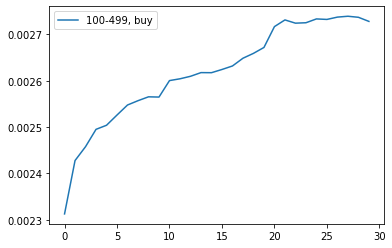

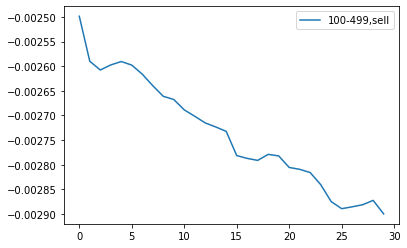

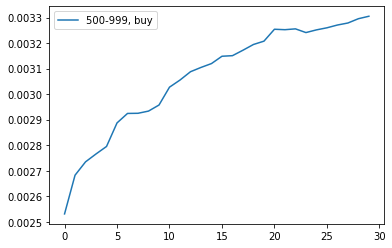

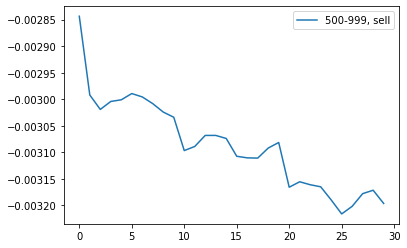

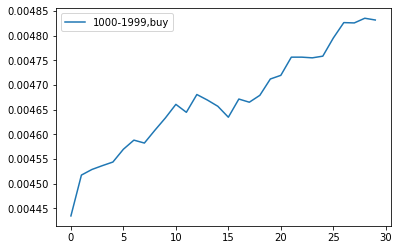

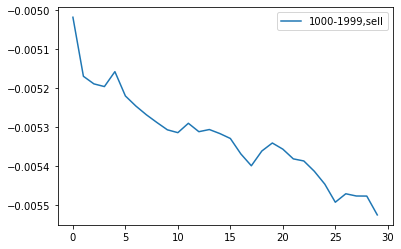

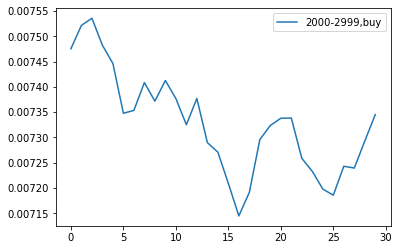

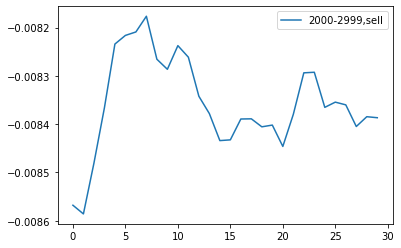

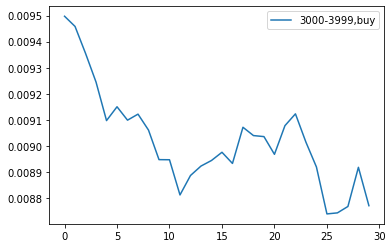

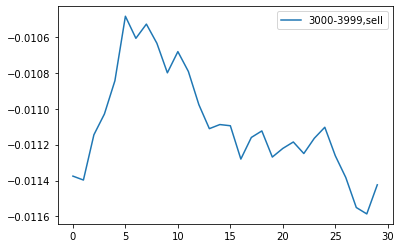

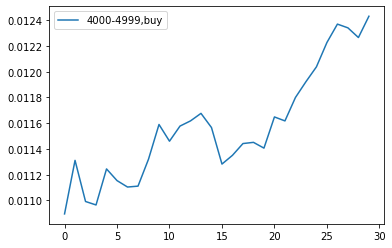

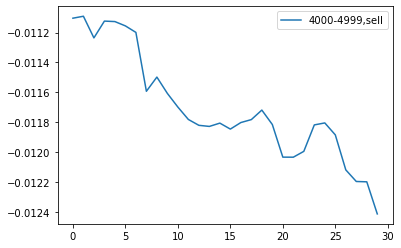

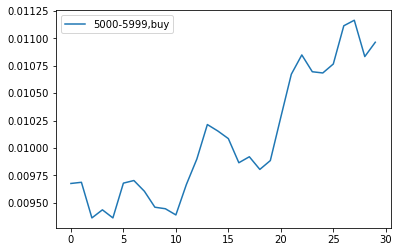

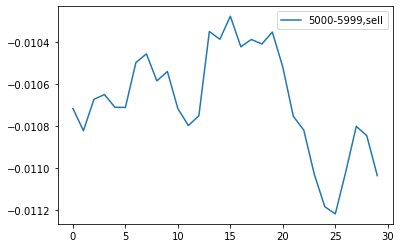

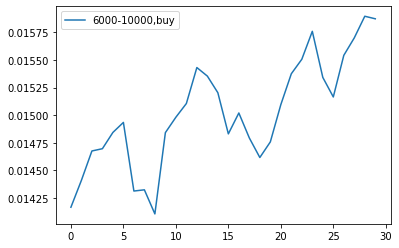

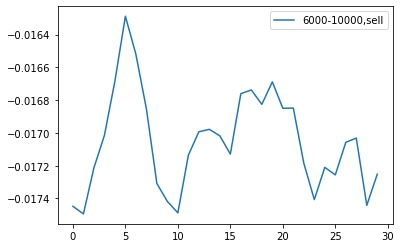

In [10]:
if not os.path.isdir('plots'):
    os.makedirs('plots')

for name, result in results.items():
    plt.plot(result, label = name)
    plt.legend()
    plt.savefig(f'./plots/{name}.png')
    plt.show()

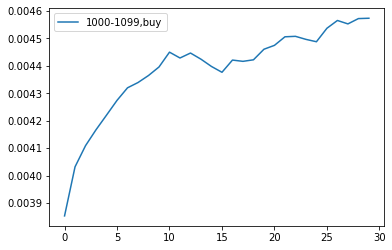

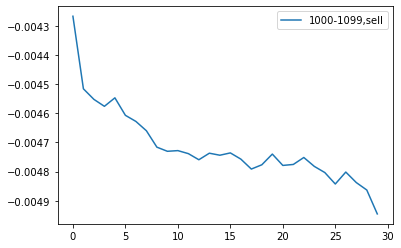

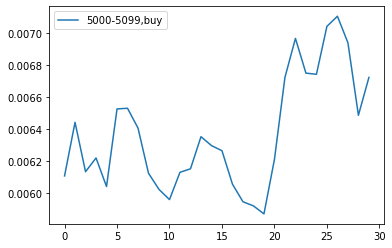

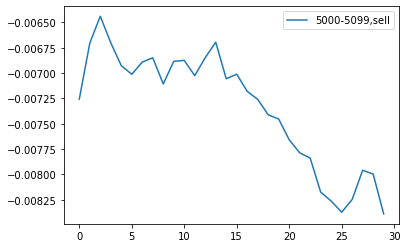

In [11]:
for name, result in results_special.items():
    plt.plot(result, label = name)
    plt.legend()
    plt.savefig(f'./plots/{name}.png')
    plt.show()

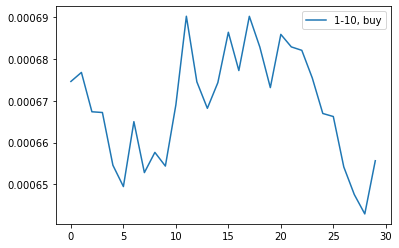

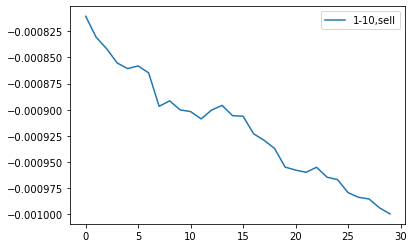

In [12]:
results_small = {
    '1-10, buy': [0.000674638349344615, 0.0006768010728923999, 0.0006673743367227907, 0.000667197547612484, 0.0006545681433722807, 0.0006494526281115961, 0.0006650052305083603, 0.0006527994800401778, 0.0006576438568868592, 0.0006543625071942303, 0.0006690334378270413, 0.000690261610755829, 0.0006745478354483215, 0.0006682012574039542, 0.0006743573607126259, 0.0006864199912836423, 0.0006772543373819198, 0.000690244132624408, 0.0006828790437201715, 0.0006731648321887977, 0.0006859154507447405, 0.0006829180155769227, 0.0006820928538634231, 0.0006754517131051869, 0.0006669634161597977, 0.0006662362675509163, 0.0006541544771039909, 0.0006475476576638539, 0.00064290072278066, 0.0006556423234102915],
    '1-10,sell':[-0.0008105444322551417, -0.0008305906282124886, -0.0008416277816950977, -0.0008552223764547843, -0.0008606272156092547, -0.000858046846331971, -0.0008647410011339178, -0.0008967152098553391, -0.0008914328411722945, -0.0009000898562426455, -0.0009017539458568193, -0.000908722730544783, -0.0009002481940896572, -0.000895840240699655, -0.0009056626971908554, -0.0009061926863657668, -0.0009229451762644364, -0.0009291918769624497, -0.0009370360223295445, -0.0009548064829675056, -0.0009576899774048379, -0.0009598219471922035, -0.0009549767193102216, -0.0009645072806823891, -0.000966806879838623, -0.0009792373509885867, -0.0009837489148748582, -0.0009853108741427234, -0.0009938381612321257, -0.0009996135344401027],
}

for name, result in results_small.items():
    plt.plot(result, label = name)
    plt.legend()
    plt.show()

Conclusion:
1) For a size up to 2000 lots we can see a monotonic price impact signature.<br>
   For bigger sizes it's possible that a big trade eats multiple levels of liquidity,<br>
   but then price movement can continue in any side (no strong trend in a path of big trade)<br>

2) Even a small trades have some monotonic impact (although it's strange, I expected<br>
   random walk price path after it)<br>

# Part 5. Saving signatures for further work with

In [14]:
with open('../0_CommonFiles/signature.json', 'w') as file:
    json.dump(results, file, indent=4)

with open('../0_CommonFiles/signature_special.json', 'w') as file:
    json.dump(results, file, indent=4)

Some resorting of values, that will be used in future:

In [4]:
signature_table = {
    'B': {
        (100, 499):   [0.0024905292322913285, 0.0026433182635482626, 0.002697568954515778, 0.002754871518810317, 0.0027752543082661374, 0.0028078903944222097, 0.0028371652741295862, 0.002847808719280013, 0.0028629920749483452, 0.0028644201398436335, 0.002902226078334742, 0.0029074442675728735, 0.002909906263110637, 0.002920145213701039, 0.0029235891185313977, 0.0029301488175850834, 0.0029372444769760727, 0.0029551045002256904, 0.002967188583503694, 0.0029792892963725706, 0.003030206853470199, 0.0030455028641086295, 0.0030361961146199213, 0.003037642986828899, 0.003047899841558298, 0.0030454963201911197, 0.0030526111305911024, 0.003057226325988928, 0.0030565060371562664, 0.00304376181684737],
        (500, 999):   [0.0026910899881976646, 0.002876574048739949, 0.002954233358535151, 0.003004949016366884, 0.003051637010818458, 0.003155480831982127, 0.0032022998510619623, 0.0032067194415670575, 0.0032198526432204995, 0.0032461271190022552, 0.003316403526027055, 0.003348364191854261, 0.003382860725006834, 0.0033982864133026806, 0.003416631622502073, 0.0034439206651035196, 0.0034502304663365426, 0.0034699038516893947, 0.0034927645055142713, 0.0035066473844458652, 0.003557687851464374, 0.0035595092792224665, 0.0035653776916127, 0.0035530782397924818, 0.0035613312440704622, 0.0035661420643975034, 0.0035718473977402877, 0.0035835479654684537, 0.00360718410967474, 0.0036128712728256715],
        (1000, 1999): [0.004612341943448629, 0.00470303210971194, 0.004739355350991369, 0.004756822374477201, 0.004770824837943304, 0.004812400062769874, 0.0048387798928851145, 0.004828780297409278, 0.0048642111992043355, 0.0048948626351468065, 0.004910218723984043, 0.004887823304729127, 0.004932528527765032, 0.004911338680908534, 0.004911278319943477, 0.004880698744659351, 0.004923283029468591, 0.004910424956089112, 0.004932294400206548, 0.004955211724933123, 0.004963611473046904, 0.005004210988770786, 0.005002578327983672, 0.005010618520081839, 0.0050076751191620965, 0.005044662839871767, 0.005075435694415131, 0.005073996103970367, 0.00508851019301986, 0.005083605829427722],
        (2000, 2999): [0.007666860013730193, 0.007643789023029769, 0.007652402066997683, 0.007613438051744633, 0.007614776792131339, 0.007502060470679352, 0.0075052798384596265, 0.007552209078378696, 0.007517176678966911, 0.007531715385564781, 0.007483064873911523, 0.007428261624852005, 0.007469441111481189, 0.007374616830424646, 0.0073684494057514455, 0.007305188287727694, 0.007232535700494532, 0.007274966262455883, 0.007390991475109071, 0.007427080430026108, 0.007431972843167495, 0.007426670597037147, 0.0073594906840288256, 0.00732305074441914, 0.007278815445096429, 0.007283750842030177, 0.007318336045351533, 0.007320043061559275, 0.007378172975640467, 0.007426300513799741],
        (3000, 3999): [0.009674008146040854, 0.009594498750866546, 0.009523753635455986, 0.009415641260702419, 0.009247837921464483, 0.00933503498220464, 0.009277199524990488, 0.009292350809572029, 0.009209022491318938, 0.009075989417298902, 0.009069096460127404, 0.008942232763600304, 0.009036936492981215, 0.009030853634262365, 0.009053667229322226, 0.009102777991050979, 0.009074072798063661, 0.00918350715436552, 0.0091641956874766, 0.00915439691789643, 0.00905721982629974, 0.009179315898859751, 0.009239740959752309, 0.009123399560758687, 0.009069593964616589, 0.008900625072984975, 0.008930201349958393, 0.008894070702762092, 0.009053905993548605, 0.008901185965190536],
        (4000, 4999): [0.011019889178636652, 0.011441198417186441, 0.011105431809768135, 0.011148529862105707, 0.011417548194302468, 0.011361981369996148, 0.01132618883567955, 0.011368819335707462, 0.011563397010111769, 0.011873061573159035, 0.0117197120970133, 0.01185161970097324, 0.011850805141290345, 0.01188601861527688, 0.0117790126443318, 0.011510710136511828, 0.011644152465413704, 0.011700125096293482, 0.011649358483612466, 0.011687462865742921, 0.011916583861082805, 0.011878289032676563, 0.01207941101879102, 0.012175605618630151, 0.012251549957490634, 0.01243124102886145, 0.012545704816970833, 0.012537714755208915, 0.012456087269594924, 0.012601588499248887],
        (5000, 5999): [0.009752595144464879, 0.009710915814622032, 0.009442979565791883, 0.009568342484458967, 0.009600821152447949, 0.00990578351907795, 0.009932260287593569, 0.009837965853948472, 0.00966540179856852, 0.009673962782141984, 0.009626877350233123, 0.009891261370888119, 0.010099024930627006, 0.01040851357086885, 0.010349333254191075, 0.010325257097068661, 0.01007730186831571, 0.01013435307997328, 0.010072955006161233, 0.010112540519686386, 0.010590693249442219, 0.01102417343108075, 0.011126782049952606, 0.01094982892843211, 0.010941644412129534, 0.011057090625790612, 0.011330102764629818, 0.011472762239011168, 0.011149269176548692, 0.01131296380607968],
        # ??? copy results for 5000-5999
        (6000, 1000000): [0.009752595144464879, 0.009710915814622032, 0.009442979565791883, 0.009568342484458967, 0.009600821152447949, 0.00990578351907795, 0.009932260287593569, 0.009837965853948472, 0.00966540179856852, 0.009673962782141984, 0.009626877350233123, 0.009891261370888119, 0.010099024930627006, 0.01040851357086885, 0.010349333254191075, 0.010325257097068661, 0.01007730186831571, 0.01013435307997328, 0.010072955006161233, 0.010112540519686386, 0.010590693249442219, 0.01102417343108075, 0.011126782049952606, 0.01094982892843211, 0.010941644412129534, 0.011057090625790612, 0.011330102764629818, 0.011472762239011168, 0.011149269176548692, 0.01131296380607968]
    },
    'S': {
        (100, 499):   [-0.002691961920942539, -0.0028218211718799174, -0.0028526589224838624, -0.0028580376926901057, -0.0028554915302185426, -0.0028715145253223814, -0.002892245132825392, -0.002917789041322858, -0.0029401823740718186, -0.0029468314074382472, -0.002966728525845394, -0.002982267277371796, -0.0029956516900289634, -0.0030053244866775257, -0.003014695901351538, -0.0030689010638763146, -0.0030739605354541673, -0.0030778089280789575, -0.003067598021875995, -0.0030704625041084, -0.003097924784737163, -0.0031019103469523404, -0.0031078246667001807, -0.0031344306091877928, -0.0031704390863474194, -0.0031862293510007984, -0.0031799665756465662, -0.0031765049864934634, -0.0031675934803442165, -0.0031961782294462975],
        (500, 999):   [-0.003008004466562672, -0.0031912751646871232, -0.0032467112890713526, -0.0032607366979502087, -0.0032648957081756556, -0.0032709954302336188, -0.00327360221832405, -0.0032897902474548677, -0.003308227730510537, -0.0033210146283061018, -0.003387044834705139, -0.003378095054457927, -0.0033538402745523542, -0.003355872942904236, -0.0033635644305300394, -0.003405175290050012, -0.003403924048792436, -0.0034102931548327, -0.0034047582602718396, -0.0033956189805064733, -0.0034858723031213268, -0.003465391695813379, -0.0034771176678052847, -0.00347568541315807, -0.0034998747813142833, -0.003529806317990441, -0.003506756427493522, -0.0034893681334655694, -0.0034902468507876276, -0.003508570475398435],
        (1000, 1999): [-0.005193527548200116, -0.0053838014627723444, -0.005402806578284014, -0.00543410081791218, -0.005412053312792029, -0.005472204404052999, -0.0054955736618325065, -0.005525343264595411, -0.005548110821957607, -0.005569054210315334, -0.005567431960921996, -0.005554403572277654, -0.005574627243539157, -0.0055716513554180305, -0.005573081132148346, -0.00558488020683325, -0.005629225883774346, -0.00566259193964533, -0.005622225625124084, -0.005608585487945004, -0.005625586022881097, -0.00564591369330999, -0.0056556044406593465, -0.0056854235969587, -0.005713757978951893, -0.005767603214608918, -0.005737164047361523, -0.005750507698046928, -0.005750483826174665, -0.005789134591693843],
        (2000, 2999): [-0.008772532023005432, -0.008736440237200447, -0.00864071731179626, -0.008544224583353096, -0.008405019827083185, -0.00842515509726803, -0.008430296925373905, -0.008388579154313961, -0.008475364452445133, -0.008514497085523693, -0.008438669567902289, -0.00845897993666488, -0.008502637468935552, -0.008537800517944014, -0.008599350476616795, -0.008595145849275823, -0.008548945261920009, -0.008548854374433073, -0.00856299259324292, -0.008578076602230776, -0.00860636546575176, -0.008546389272189526, -0.008434613305679736, -0.008461867077007376, -0.008513358115444467, -0.00851437134906376, -0.008506239865189079, -0.008559544883079565, -0.008537952615015552, -0.008550979625147002],
        (3000, 3999): [-0.011650249871759721, -0.011652507980316522, -0.011428646460492638, -0.011296664818182872, -0.011108769959144116, -0.010753379840007862, -0.010904103664097662, -0.010850310322040264, -0.010937717759928717, -0.011050993124673659, -0.010912228212921427, -0.011021726452862606, -0.011204422983069303, -0.011344730432164172, -0.011289843640146834, -0.011298736762360055, -0.011488414631182322, -0.01138611127223616, -0.0113674158517282, -0.011492847772814367, -0.011416581505829937, -0.011391728273509281, -0.011444262948521505, -0.01137037579692953, -0.011301540836656656, -0.011478391220936683, -0.01160197606041419, -0.011795934700036221, -0.011818350553284658, -0.011633203311841384],
        (4000, 4999): [-0.01114950631995241, -0.011162250593862581, -0.011277315685737942, -0.011209797128188783, -0.011291138714941919, -0.01130973134553277, -0.011351357282652547, -0.01177774409391618, -0.011679075618075754, -0.011799609730924856, -0.011860618116177024, -0.011917534319117894, -0.011961431612554935, -0.011983307015411214, -0.011982966390406156, -0.012080630394631866, -0.01200226885101033, -0.011999803941175459, -0.011898603325597674, -0.012018945611891872, -0.012245730524373012, -0.012279839944683716, -0.012227665359045589, -0.012035700438750357, -0.011993569730108572, -0.01203636668121768, -0.012261569331689435, -0.012357793037477716, -0.012332823490384233, -0.012573643228148244],
        (5000, 5999): [-0.010886281841212774, -0.010909766916686381, -0.01084644532848205, -0.010833785438672647, -0.01090003835236758, -0.010924942169616725, -0.010740406167922462, -0.010668919209943352, -0.01079079193381028, -0.010737813976872946, -0.010938418645686548, -0.010975720465114053, -0.010862777731241006, -0.010468382338453026, -0.01049630362309003, -0.010400533002998109, -0.010530070150458842, -0.01048533193953031, -0.010392612827167066, -0.010397852353878892, -0.010575881143408163, -0.01078093641122272, -0.010823641380151126, -0.011011893532463452, -0.011201870383060286, -0.011250730937168022, -0.011125539631192187, -0.01093584323456253, -0.010944043691882706, -0.011085875722578327],
#         # ??? copy results for 5000-5999
         (6000, 1000000): [-0.010886281841212774, -0.010909766916686381, -0.01084644532848205, -0.010833785438672647, -0.01090003835236758, -0.010924942169616725, -0.010740406167922462, -0.010668919209943352, -0.01079079193381028, -0.010737813976872946, -0.010938418645686548, -0.010975720465114053, -0.010862777731241006, -0.010468382338453026, -0.01049630362309003, -0.010400533002998109, -0.010530070150458842, -0.01048533193953031, -0.010392612827167066, -0.010397852353878892, -0.010575881143408163, -0.01078093641122272, -0.010823641380151126, -0.011011893532463452, -0.011201870383060286, -0.011250730937168022, -0.011125539631192187, -0.01093584323456253, -0.010944043691882706, -0.011085875722578327]
    }
}

special_signature_table = {
    'B': {
        (1000, 1099):[0.0038529617164793206, 0.00403181908404838, 0.004108932188464825, 0.004166920316489643, 0.004220155582077373, 0.004273912501334864, 0.004319697680931575, 0.004338926561576572, 0.004364529897748136, 0.004395575977771648, 0.004449555339757789, 0.004428318698264448, 0.004446364955414749, 0.004423926149845273, 0.004397436712020977, 0.004376260060215742, 0.0044207347520341545, 0.004416103928423967, 0.0044217104702626705, 0.004460237630314895, 0.004474359955354541, 0.004505564968242821, 0.004507257813362308, 0.004496167501252911, 0.004487526707814469, 0.004536643654495407, 0.004565011071383859, 0.004552547456309918, 0.004571904533510294, 0.0045731413648506],
        (5000, 5099):[0.006106957883814215, 0.00644269383931899, 0.006133377255925495, 0.006219659157975358, 0.0060405938813240705, 0.006526618699849522, 0.006530853038624459, 0.0064065378297375524, 0.006123868493675033, 0.006022575795003856, 0.005958748517358059, 0.0061298343885650705, 0.006151645469121049, 0.006352785277766507, 0.0062970267005466925, 0.006264765824149917, 0.006055442836793935, 0.005945243684471735, 0.005919385445784845, 0.0058690902989523425, 0.006210556404345244, 0.006724353428389823, 0.006968471037284378, 0.006750916042532846, 0.00674363309470233, 0.00704396939267912, 0.007107182178586039, 0.006941285689157912, 0.006486805476789233, 0.006723872038080861]
    },
    'S': {
        (1000, 1099):[-0.004267209632235655, -0.004516122289813329, -0.004552296276632397, -0.004576134980358797, -0.0045470416276897066, -0.00460699801333472, -0.004627913319090007, -0.004659879365050141, -0.00471616667313095, -0.004730362131057563, -0.00472804606862145, -0.004738397126575551, -0.004759342868232753, -0.0047369114131551125, -0.004743851662231028, -0.0047359185533517745, -0.004757162523388513, -0.004791298562038588, -0.004776632541310709, -0.00473993771589973, -0.0047788472702983255, -0.004775486963989861, -0.004751609959192705, -0.0047821259672853654, -0.004803237145091124, -0.004842560407047154, -0.004801582302526759, -0.0048376030746216355, -0.004863158424504522, -0.0049451361681136135],
        (5000, 5099):[-0.007257735609878114, -0.006704748528699831, -0.006439474794717492, -0.006701536259367508, -0.006926654773923445, -0.0070126946934892555, -0.006891817246988747, -0.006849701204757692, -0.007108166177774079, -0.006884181298510419, -0.0068753444795149115, -0.007025884964673719, -0.006848278652181571, -0.006695916265532481, -0.00705631687832226, -0.007011524936976319, -0.007180927260406394, -0.007259407630869875, -0.007412178247155728, -0.007454485287823414, -0.007658695588282442, -0.0077873936413261164, -0.007839811170311493, -0.008175082109910844, -0.008263993409375076, -0.008373915775517903, -0.008248108511888558, -0.007959638875965284, -0.007996909614858288, -0.008390615494695374]
    }
}